# Investigating the quadratic speed-up of Quantum-enhanced Reflecting Projective Simulation

Sofiène Jerbi (sofiene.jerbi@telecom-paristech.fr)

In [1]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from numpy import pi, sqrt

np.set_printoptions(suppress=True)

A useful function we define to be used all along the notebook.

In [2]:
def measure(state, size=1):
    """For a given state returns a measurement (or \'size\' measurements, if specified) of the state in
    the computational basis along with its wavefunction (probabilities of each outcome)"""
    n = state.shape[0]
    probs = np.abs(state.dag().full())**2
    probs = probs.reshape(n)
    if size>1:
        draw = np.random.choice(n,p=probs,size=size)
    else:
        draw = np.random.choice(n,p=probs)
    return(draw,list(probs))

In [3]:
bell = (basis(2,0)+basis(2,1))/math.sqrt(2)
print(measure(bell))

(1, [0.49999999999999989, 0.49999999999999989])


<h1>Rank-One Reflecting PS</h1>

The aim of the following part if to show how quantum-enhancement allows to keep one of the good features of PS, its reactivity to environment changes, even when adding an additional structure (Reflecting PS and flags) that increases learning efficiency but induces longer deliberation times, especially in the case of changes in the environment.
Let us set the context and explain this further:

We consider the case of a "two-layered" RPS agent, where each transition matrix $P$ associated to the MC of a percept-specific sub-network of the ECM have rank one. We focus on the sub-network associated to one percept but we would get analog results for the other percepts. As specified in the appendix of https://arxiv.org/pdf/1407.2830.pdf this leads to many simplifications:
- The columns of $P$ are all identical, equal to the stationary distribution, so all unitaries $U_i$ are the same equal to $U$ (given by formula A.1)
- $P$ has only one eigenvalue (+1) and one eigenvector (the stationary distribution) which leads to a spectral gap $\delta = 1$
- The Markov chain mixes in one step
- The Szegedy Walk operator becomes $W(P) = UD_0U^\dagger$ and is Hermitian, then exact reflection over the stationary distribution can be achieved by applying $W(P)$ once on only one register

We deal with the simple "Invasion game" with a set of three percepts and three actions. We define the stationnary action probabilities $\pi = (\pi_1,\pi_2,\pi_3)$ and add the *flags* (or *emoticons*) structure to the network, increasing the learning efficiency of the agent but inducing a longer deliberation time to output an action because of the multiple reflections the RPS agent has to go through to output a *flagged* action. This number of reflections is determined by $\epsilon = \sum_{i\in F} \pi_i$ the relative probability of flagged actions within the stationary distribution, scaling as $\tilde{O}(1/\sqrt{\epsilon})$ for the quantum RPS agent and as $\tilde{O}(1/\epsilon)$ for the classical RPS agent.

To exhibit the better reactivity of quantum RS to environment changes, which happens to be the case when epsilon is the smallest (so when the difference in the dependencies on $\epsilon$ is the largest), we deal with the change in strategy of the adversary (i.e. the environment) by permuting the meaning of percepts. Suppose the adversary pursues a consistent strategy (i.e. gives the same hints, or percepts, to the agent before each of its moves) for a long period of time. The agent would have learned well, which means that for a given percept he would associated with high probability an action (i.e. $\pi_3 >> \pi_1 +\pi_2$ for example) and only the action clip associated to $\pi_3$ would be flagged. Then the adversary changes his strategy, which means that now the flagged actions are reset, and become (after one unsuccessful trial on the action associated to $\pi_3$) the actions clips associated to $\pi_1$ and $\pi_2$, with cumulated probability $\epsilon = \pi_1 +\pi_2 << 1$.

Let's now dig into the simulation!

In [6]:
epsilon = 0.1
p1 = epsilon/3
p2 = epsilon-p1
p3 = 1-epsilon
distrib = [p1,p2,p3/2,p3/2]

We define $U$ with the formula A.1 given in the paper.

In [7]:
Ux = (0.5*math.pi*0.5j*(tensor(sigmax(),qeye(2))+tensor(qeye(2),sigmax()))).expm()
Uz2 = tensor(qeye(2),rz(2*math.acos(sqrt(p1/epsilon))))
Uz1 = tensor(rz(2*math.acos(sqrt(epsilon))),qeye(2))
Uxb = (-0.5*math.pi*0.5j*(tensor(sigmax(),qeye(2))+tensor(qeye(2),sigmax()))).expm()

In [8]:
U = Ux*Uz2*Uz1*Uxb
U

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.18257419 -0.25819889 -0.54772256  0.77459667]
 [ 0.25819889  0.18257419 -0.77459667 -0.54772256]
 [ 0.54772256 -0.77459667  0.18257419 -0.25819889]
 [ 0.77459667  0.54772256  0.25819889  0.18257419]]

In [9]:
U.dag()*U

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]

In [10]:
print(measure(U*tensor(basis(2,0),basis(2,0)))[1])

[0.033333333333333319, 0.066666666666666735, 0.29999999999999993, 0.60000000000000009]


$U$ applied to the state |$0$> indeed gives the distribution

Then we need to define the reflection over the flagged actions $Uz1b$ and the Szegedy walk operator $W$

In [11]:
Uz1b = tensor(rz(pi),qeye(2))
Uz1b

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.-1.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.-1.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+1.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+1.j]]

In [12]:
null = tensor(basis(2,0),basis(2,0))
D0 = 2*null*null.dag()-tensor(qeye(2),qeye(2))

In [13]:
W = U*D0*U.dag()

In [14]:
def simulation_rankone(step_e, max_e, nb_agnts, clssc=False):
    """
    simulation_rankone simulates for nb_agnts agents the quantum walk (and also the classical walk if clssc is set)
    on the subnetwork associated to the first percept for epsilon <= max_e with step step_e. It stores the number of
    calls of U before a flagged action is hit for each simulation in NUss for the quantum agents and in NUss_clssc for
    the classical agents. It also stores the number of times the first percept or the second percept are hit in N1s
    and N2s respectively.
    """
    epsilons = np.arange(max_e, 0.0-step_e, -step_e)[:-1]
    N1s = []
    N2s = []
    NUss = []
    NUss_clssc = []
    flagged = 1
    old_perc = 0
    for epsilon in epsilons:
        p1 = epsilon/3
        Uz2 = tensor(qeye(2),rz(2*math.acos(sqrt(p1/epsilon))))
        Uz1 = tensor(rz(2*math.acos(sqrt(epsilon))),qeye(2))
        U = Ux*Uz2*Uz1*Uxb
        W = U*D0*U.dag()
        me = math.ceil(1/sqrt(epsilon))
        N1 = 0
        N2 = 0
        NUs = []
        NUs_clssc = []
        for i in range(nb_agnts):
            NU = 0
            fnd = False
            while not fnd:
                R1 = tensor(basis(2,0),basis(2,0))
                m = random.randint(0,me)
                NU+=3*m
                R1 = U*R1
                for j in range(m):
                    R1 = Uz1b*R1
                    R1 = W*R1
                res = measure(R1)[0]
                if res<=flagged:
                    fnd = True
                    if res==0:
                        N1+=1
                    else:
                        N2+=1
            NUs+=[NU]
            if clssc:
                NU = 0
                fnd = False
                while not fnd:
                    NU+=1
                    R1 = tensor(basis(2,0),basis(2,0))
                    R1 = U*R1
                    res = measure(R1)[0]
                    if res<=flagged:
                        fnd = True
                NUs_clssc+=[NU]
        NUss+=[NUs]
        NUss_clssc+=[NUs_clssc]
        N1s+=[N1]
        N2s+=[N2]
        perc = 100*(1-epsilon/epsilons[0])
        if perc >= old_perc+10:
            old_perc = 10*int(perc/10)
            print(int(perc),"%")
    print("done")
    if clssc:
        return(epsilons, NUss, NUss_clssc, N1s, N2s)
    else:
        return(epsilons, NUss, N1s, N2s)

In [15]:
epsilonsb, NUssb, NUssb_classc, N1s, N2s = simulation_rankone(0.0005, 0.05, 1000, True)

10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
done


In [63]:
#We save the data in a pickle file
import pickle
f = open('simulation_epsilon_noerror.save', 'wb')
pickle.dump([epsilonsb, NUssb, NUssb_classc, N1s, N2s], f)
f.close()

In [3]:
import pickle
file = open('simulation_epsilon_noerror.save', 'rb')
[epsilonsb, NUssb, NUssb_classc, N1s, N2s] = pickle.load(file)
file.close()

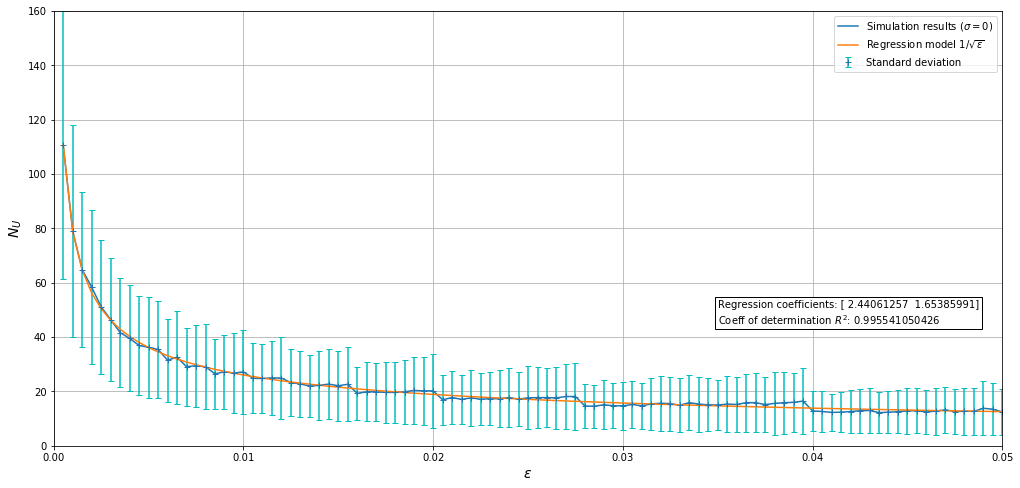

Curve fitting coefficients :  [ 2.44061257  1.65385991]
Coefficient of determination R^2 :  0.995541050426


In [4]:
#Quantum case plot
NUssb_mean = []
NUssb_std = []
for NUs in NUssb:
    NUssb_mean+=[np.mean(NUs)]
    NUssb_std+=[np.std(NUs)]

curve_fit = np.polyfit(1/np.sqrt(epsilonsb), NUssb_mean, 1, full=True)
coeff = curve_fit[0]
res = curve_fit[1][0]
rsqr = 1 - res / (len(NUssb_mean) * np.var(NUssb_mean))

plt.figure(figsize=(17,8))
errbar = plt.errorbar(epsilonsb, NUssb_mean, np.array(NUssb_std), ecolor='c', linestyle='None', marker='+', capsize=3, label='Standard deviation')
results, = plt.plot(epsilonsb, NUssb_mean, label='Simulation results ($\sigma=0$)')
model, = plt.plot(epsilonsb, coeff[0]/np.sqrt(epsilonsb)+coeff[1], label='Regression model $1/\sqrt{\epsilon}$')
axes = plt.gca()
axes.set_ylim([0,160])
axes.set_xlim([0,0.05])

plt.legend(handles=[results, model, errbar])
plt.text(0.035,45,'Regression coefficients: '+str(coeff)+'\nCoeff of determination $R^2$: '+str(rsqr),bbox=dict(facecolor='white',edgecolor='black',boxstyle='square'))

plt.xlabel('$\epsilon$', fontsize=14)
plt.ylabel('$N_U$', fontsize=14)
plt.grid(True)
plt.show()
print("Curve fitting coefficients : ", coeff)
print('Coefficient of determination R^2 : ', rsqr)

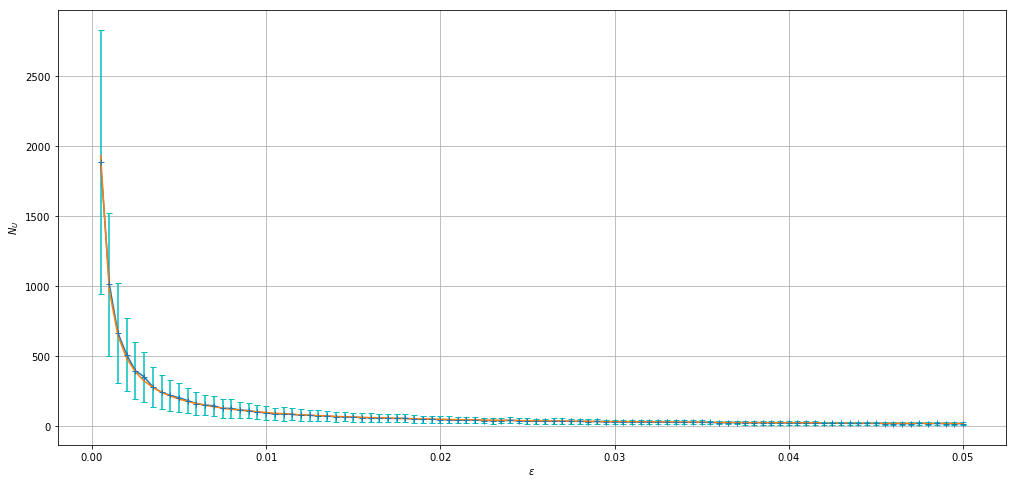

Curve fitting coefficients :  [ 0.96559284  2.58519811]
Coefficient of determination R^2 :  0.998645652408


In [50]:
#Classical case plot
NUssb_clssc_mean = []
NUssb_clssc_std = []
for NUs in NUssb_classc:
    NUssb_clssc_mean+=[np.mean(NUs)]
    NUssb_clssc_std+=[np.std(NUs)]

curve_fit = np.polyfit(1/np.array(epsilonsb), NUssb_clssc_mean, 1, full=True)
coeff = curve_fit[0]
res = curve_fit[1][0]
rsqr = 1 - res / (len(NUssb_clssc_mean) * np.var(NUssb_clssc_mean))

plt.figure(figsize=(17,8))
plt.plot(epsilonsb, NUssb_clssc_mean)
plt.plot(epsilonsb, coeff[0]/np.array(epsilonsb)+coeff[1])
plt.errorbar(epsilonsb, NUssb_clssc_mean, np.array(NUssb_clssc_std)/2, ecolor='c', linestyle='None', marker='+', capsize=3)

plt.xlabel('$\epsilon$')
plt.ylabel('$N_U$')
plt.grid(True)
plt.show()
print("Curve fitting coefficients : ", coeff)
print('Coefficient of determination R^2 : ', rsqr)

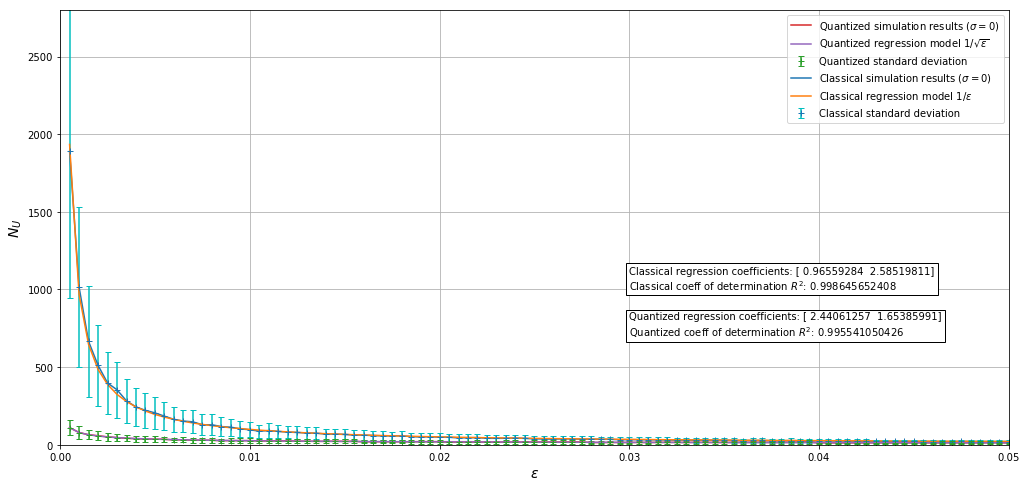

In [5]:
#Comparison plot
NUssb_mean = []
NUssb_std = []
for NUs in NUssb:
    NUssb_mean+=[np.mean(NUs)]
    NUssb_std+=[np.std(NUs)]

NUssb_clssc_mean = []
NUssb_clssc_std = []
for NUs in NUssb_classc:
    NUssb_clssc_mean+=[np.mean(NUs)]
    NUssb_clssc_std+=[np.std(NUs)]

curve_fit_clssc = np.polyfit(1/np.array(epsilonsb), NUssb_clssc_mean, 1, full=True)
coeff_clssc = curve_fit_clssc[0]
res_clssc = curve_fit_clssc[1][0]
rsqr_clssc = 1 - res_clssc / (len(NUssb_clssc_mean) * np.var(NUssb_clssc_mean))

plt.figure(figsize=(17,8))
results_clssc, = plt.plot(epsilonsb, NUssb_clssc_mean, label='Classical simulation results ($\sigma=0$)')
model_clssc, = plt.plot(epsilonsb, coeff_clssc[0]/np.array(epsilonsb)+coeff_clssc[1], label='Classical regression model $1/\epsilon$')
errbar_clssc = plt.errorbar(epsilonsb, NUssb_clssc_mean, np.array(NUssb_clssc_std)/2, ecolor='c', linestyle='None', marker='+', capsize=3, label='Classical standard deviation')

curve_fit = np.polyfit(1/np.sqrt(epsilonsb), NUssb_mean, 1, full=True)
coeff = curve_fit[0]
res = curve_fit[1][0]
rsqr = 1 - res / (len(NUssb_mean) * np.var(NUssb_mean))

errbar = plt.errorbar(epsilonsb, NUssb_mean, np.array(NUssb_std), linestyle='None', marker='+', capsize=3, label='Quantized standard deviation')
results, = plt.plot(epsilonsb, NUssb_mean, label='Quantized simulation results ($\sigma=0$)')
model, = plt.plot(epsilonsb, coeff[0]/np.sqrt(epsilonsb)+coeff[1], label='Quantized regression model $1/\sqrt{\epsilon}$')
axes = plt.gca()
axes.set_xlim([0,0.05])
axes.set_ylim([0,2800])

plt.legend(handles=[results, model, errbar, results_clssc, model_clssc, errbar_clssc])
plt.text(0.03,1000,'Classical regression coefficients: '+str(coeff_clssc)+'\nClassical coeff of determination $R^2$: '+str(rsqr_clssc),bbox=dict(facecolor='white',edgecolor='black',boxstyle='square'))
plt.text(0.03,700,'Quantized regression coefficients: '+str(coeff)+'\nQuantized coeff of determination $R^2$: '+str(rsqr),bbox=dict(facecolor='white',edgecolor='black',boxstyle='square'))

plt.xlabel('$\epsilon$', fontsize=14)
plt.ylabel('$N_U$', fontsize=14)
plt.grid(True)
plt.show()

We clearly get the quadratic seperation between the classical agents and the quantum agents as expected, proving by simulation the quantum-enhancement.

<h1>Rank-two Reflecting PS</h1>

We showed in the previous section how quantum-enhancement of the RPS model allowed to keep the good reactivity of the agent to environment changes. Let us now show another good feature of the PS the quantum-enhancement preserves, the nice interplay between planning and real-time action selection.

Indeed, in a more general case than the rank-one RPS, the ergodic MCs of the percept-specific subnetworks of the ECM don't completely mix in one step. This is because the mixing time of the MC (the number of applications of the transition matrix $P$ on an initial distribution to get a *good* approximation of the stationary distribution) is inversely dependent of the spectral gap $\delta = 1 - |\lambda|$ (where $\lambda$ is the largest eigenvalue of $P$ in absolute value after 1). But this mixing time is precisely the planning in the future that the agent performs as the more the MC is mixed, the better the stationary distribution is approximated and the more accurate is the planning of the agent. The mixing time or the number of application of $P$ (or $W(P)$ for the quantum agent) is determined by the spectral gap $\delta$ scaling as $\tilde{O}(1/\sqrt{\delta})$ for the quantum RPS agent and as $\tilde{O}(1/\delta)$ for the classical RPS agent.

To show these dependencies, we consider a transition matrix $P$ with eigenvalues 1 and $\lambda$, with $\lambda$ set arbitrarily through a transformation of the rank-on transition matrix we had above:
\begin{split}\begin{pmatrix}
p_1+\lambda & p_1 & p_1 & p_1\\
p_2-\lambda & p_2 & p_2 & p_2\\
p_3 & p_3 & p_3 & p_3\\
p_4 & p_4 & p_4 & p_4
\end{pmatrix}\end{split}
where $(p_1, p_2, p_3, p_4)$ refers to the stationary distribution in the previous case.

Then the simplifications made in the first part disappear, we need to define different unitaries $U_1$ and $U_{\{2,3,4\}}$ for the first and {second, third and fourth} percepts respectively and apply the general Szegedy quantum walk operator and Phase Estimation algorithm. The stationary distribution becomes $(\frac{p_1}{1-\lambda}, p_2-p_1\times \frac{\lambda}{1-\lambda}, p_3, p_4)$.<br/>
The constraints we have on $\lambda$ (supposing it is positive) are:
\begin{split}\begin{cases}
\frac{p_1}{1-\lambda} \leq 1 \\
p_2-p_1\times \frac{\lambda}{1-\lambda} \geq 0 \\
p_1+\lambda \leq 1 \\
p_2-\lambda \geq 0
\end{cases}\end{split}

Which sum up to $\lambda \in [0, min(1-p_1, p_2, \frac{p_2}{p_1+p_2})]$. That can be further simplified if we take $p_1 < p_2$ and $p_1+p_2 < 1$ to $\lambda \in [0, p_2]$

Let us first check these previous results on the transition matrix for a given $\lambda = 0.2$:

In [697]:
epsilon = 0.6
p1 = epsilon/3
p2 = epsilon-p1
p3 = 1-epsilon
distrib = [p1,p2,p3/2,p3/2]

In [705]:
from numpy import linalg as LA
Pb = np.array([distrib]*4).transpose()
P = np.array([distrib]*4).transpose()
lmbd = 0.2
Pb[0][0] += lmbd
Pb[1][0] -= lmbd
print(P)
print(Pb)

[[ 0.2  0.2  0.2  0.2]
 [ 0.4  0.4  0.4  0.4]
 [ 0.2  0.2  0.2  0.2]
 [ 0.2  0.2  0.2  0.2]]
[[ 0.4  0.2  0.2  0.2]
 [ 0.2  0.4  0.4  0.4]
 [ 0.2  0.2  0.2  0.2]
 [ 0.2  0.2  0.2  0.2]]


In [700]:
np.set_printoptions(suppress=True)
print(LA.eig(P))
LA.eig(Pb)

(array([ 0.+0.j,  1.+0.j,  0.+0.j,  0.-0.j]), array([[-0.85280287+0.j, -0.37796447+0.j, -0.85280287+0.j, -0.85280287-0.j],
       [ 0.42640143+0.j, -0.75592895+0.j,  0.42640143+0.j,  0.42640143-0.j],
       [ 0.21320072+0.j, -0.37796447+0.j,  0.21320072+0.j,  0.21320072-0.j],
       [ 0.21320072+0.j, -0.37796447+0.j,  0.21320072+0.j,  0.21320072-0.j]]))


(array([ 1. ,  0.2,  0. ,  0. ]),
 array([[-0.48564293, -0.70710678,  0.        , -0.        ],
        [-0.6799001 ,  0.70710678, -0.        ,  0.81649658],
        [-0.38851434,  0.        , -0.70710678, -0.40824829],
        [-0.38851434,  0.        ,  0.70710678, -0.40824829]]))

As we can see the transition matrix for the previous case has eigenvalue 1 only, whereas the modified transition matrix has eigenvalues 1 and $\lambda$

Now we also check that the stationnary distribution for this new transition matrix is the one we gave above.

In [704]:
stat_distrib = [p1/(1-lmbd),p2-p1*lmbd/(1-lmbd),p3/2,p3/2]
print(stat_distrib)
Pb.dot(stat_distrib)

[0.24999999999999997, 0.35000000000000003, 0.2, 0.2]


array([ 0.25,  0.35,  0.2 ,  0.2 ])

Here we try to simulate the complete algorithm, which turns out to be a lot more complex than in the previous case.

In [712]:
# we set a variable n of direct use later when we have to set the number of auxilary qubits for the phase estimation algorithm
n=2
# the value of n sets the spectral gap, and by transitivity the value of the eigenvalue lambda
lmbd = 1 - 2**(-2*n)
# we set p2 to lambda so we have maximal upper bound on lambda
p2 = lmbd
# this value of p1 gives a probility for the first action in the stationary distribution equal to 0.25
p1 = (1-lmbd)/4
p3 = 1-p1-p2
distrib = [p1,p2,p3/2,p3/2]

R1 = tensor(basis(2,0),basis(2,0))
R2 = tensor(basis(2,0),basis(2,0))
R = tensor(R1,R2)

# coherent controlization to define the unitaries U1 and U{2,3,4}
Ut1 = tensor(ry(2*math.acos(sqrt(p1+p2))),qeye(2))
Ut2 = controlled_gate(ry(2*math.acos(sqrt(p1/(p1+p2)))), control_value=0)
Ut2b = controlled_gate(ry(2*math.acos(sqrt((p1+lmbd)/(p1+p2)))), control_value=0)
Ut3 = controlled_gate(ry(pi/2))
U1 = Ut3*Ut2b*Ut1
U2 = Ut3*Ut2*Ut1

We check that $U_1$ and $U_{\{2,3,4\}}$ work as expected.

In [715]:
print(np.sqrt([p1+lmbd,p2-lmbd,p3/2,p3/2]))
U1*R1

[ 0.97628121  0.          0.15309311  0.15309311]


Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 0.97628121]
 [ 0.        ]
 [ 0.15309311]
 [ 0.15309311]]

In [716]:
print(np.sqrt(distrib))
U2*R2

[ 0.125       0.96824584  0.15309311  0.15309311]


Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 0.125     ]
 [ 0.96824584]
 [ 0.15309311]
 [ 0.15309311]]

Now we can construct $U_p$. For that we can apply $Id \otimes U_2$ followed by a controlled $U_1 \times U_2^\dagger$ when the state in the first register is $00=c_1$.

In [717]:
U2dc00 = tensor(tensor(fock_dm(2, 0), fock_dm(2, 0)),U2.dag()-tensor(qeye(2),qeye(2)))+tensor(tensor(qeye(2),qeye(2)),tensor(qeye(2),qeye(2)))
U1c00 = tensor(tensor(fock_dm(2, 0), fock_dm(2, 0)),U1-tensor(qeye(2),qeye(2)))+tensor(tensor(qeye(2),qeye(2)),tensor(qeye(2),qeye(2)))

In [718]:
U2dc00

Quantum object: dims = [[2, 2, 2, 2], [2, 2, 2, 2]], shape = (16, 16), type = oper, isherm = False
Qobj data =
[[ 0.125       0.96824584  0.15309311  0.15309311  0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [-0.96824584  0.125      -0.15309311  0.15309311  0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [-0.0277208  -0.21472438  0.69033506  0.69033506  0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.21472438 -0.0277208  -0.69033506  0.69033506  0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
 

In [719]:
U1c00

Quantum object: dims = [[2, 2, 2, 2], [2, 2, 2, 2]], shape = (16, 16), type = oper, isherm = False
Qobj data =
[[ 0.97628121  0.         -0.21650635  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.97628121  0.         -0.21650635  0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.15309311 -0.15309311  0.69033506 -0.69033506  0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.15309311  0.15309311  0.69033506  0.69033506  0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
 

Because we are not in the time-reversible case of the Markov Chain, we need to define the time-reversed transition matrix $P^*$, for which $p_{ij}^*=p_{ji}(\pi_P)_i/(\pi_P)_j$ where $\pi_P$ denotes the stationary distribution.

In [720]:
Pb = np.array([distrib]*4).transpose()
Pb[0][0] += lmbd
Pb[1][0] -= lmbd
stat_distrib = [p1/(1-lmbd),p2-p1*lmbd/(1-lmbd),p3/2,p3/2]
print(stat_distrib)

[0.25, 0.703125, 0.0234375, 0.0234375]


In [721]:
Pb_rvrs = Pb*np.array(stat_distrib)
Pb_rvrs = Pb_rvrs.transpose()/np.array(stat_distrib)
Pb_rvrs

array([[ 0.953125  ,  0.        ,  0.25      ,  0.25      ],
       [ 0.04394531,  0.9375    ,  0.703125  ,  0.703125  ],
       [ 0.00146484,  0.03125   ,  0.0234375 ,  0.0234375 ],
       [ 0.00146484,  0.03125   ,  0.0234375 ,  0.0234375 ]])

Cohrent controlization is then needed again to define $P^*$'s unitaries.

In [722]:
prv1 = Pb_rvrs[:,0]
prv2 = Pb_rvrs[:,1]
prv3 = Pb_rvrs[:,2]

Urt1 = tensor(ry(2*math.acos(sqrt(prv1[0]+prv1[1]))),qeye(2))
Urt1b = tensor(ry(2*math.acos(sqrt(prv2[0]+prv2[1]))),qeye(2))
Urt1c = tensor(ry(2*math.acos(sqrt(prv3[0]+prv3[1]))),qeye(2))
Urt2 = controlled_gate(ry(2*math.acos(sqrt(prv1[0]/(prv1[0]+prv1[1])))), control_value=0)
Urt2b = controlled_gate(ry(2*math.acos(sqrt(prv2[0]/(prv2[0]+prv2[1])))), control_value=0)
Urt2c = controlled_gate(ry(2*math.acos(sqrt(prv3[0]/(prv3[0]+prv3[1])))), control_value=0)
Urt3 = controlled_gate(ry(pi/2))
Ur1 = Urt3*Urt2*Urt1
Ur2 = Urt3*Urt2b*Urt1b
Ur3 = Urt3*Urt2c*Urt1c

In [723]:
print(np.sqrt(prv1))
Ur1*R1

[ 0.97628121  0.20963137  0.03827328  0.03827328]


Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 0.97628121]
 [ 0.20963137]
 [ 0.03827328]
 [ 0.03827328]]

In [724]:
print(np.sqrt(prv2))
Ur2*R1

[ 0.          0.96824584  0.1767767   0.1767767 ]


Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 0.        ]
 [ 0.96824584]
 [ 0.1767767 ]
 [ 0.1767767 ]]

In [725]:
print(np.sqrt(prv3))
Ur3*R1

[ 0.5         0.83852549  0.15309311  0.15309311]


Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 0.5       ]
 [ 0.83852549]
 [ 0.15309311]
 [ 0.15309311]]

In [726]:
Ur1c00 = tensor(tensor(fock_dm(2, 0), fock_dm(2, 0)),Ur1*Ur3.dag()-tensor(qeye(2),qeye(2)))+tensor(tensor(qeye(2),qeye(2)),tensor(qeye(2),qeye(2)))
Ur2c01 = tensor(tensor(fock_dm(2, 0), fock_dm(2, 1)),Ur2*Ur3.dag()-tensor(qeye(2),qeye(2)))+tensor(tensor(qeye(2),qeye(2)),tensor(qeye(2),qeye(2)))

Now we have everything to define the Szegedy Walk operator $W(P)$.

In [628]:
Up = U1c00*U2dc00*tensor(tensor(qeye(2),qeye(2)),U2)
Vp_temp = Ur1c00*Ur2c01*tensor(tensor(qeye(2),qeye(2)),Ur3)
Vp = swap(N=4, targets=[0, 2])*swap(N=4, targets=[1, 3])*Vp_temp*swap(N=4, targets=[0, 2])*swap(N=4, targets=[1, 3])
null = tensor(basis(2,0),basis(2,0))
D0 = 2*null*null.dag()-tensor(qeye(2),qeye(2))
refA = Up*tensor(tensor(qeye(2),qeye(2)),D0)*Up.dag()
refB = Vp*tensor(D0,tensor(qeye(2),qeye(2)))*Vp.dag()
W = refB*refA

Let us now check that the state |$\pi'_P$> $= \sum\nolimits_{i} \sqrt{(\pi_P)_i} $ |$c_i$>$_I $ $U_i$|$0$>$_{II}$ is a 1-eigenstate of $W(P)$

In [630]:
stat_1 = sqrt(p1/(1-lmbd))*tensor(basis(2,0),basis(2,0))+sqrt(p2-p1*lmbd/(1-lmbd))*tensor(basis(2,0),basis(2,1))+sqrt(p3/2)*tensor(basis(2,1),basis(2,0))+sqrt(p3/2)*tensor(basis(2,1),basis(2,1))
stat_1

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 0.5       ]
 [ 0.83852549]
 [ 0.15309311]
 [ 0.15309311]]

In [727]:
stat = Up*tensor(stat_1,R2)
stat

Quantum object: dims = [[2, 2, 2, 2], [1, 1, 1, 1]], shape = (16, 1), type = ket
Qobj data =
[[ 0.4881406 ]
 [ 0.        ]
 [ 0.07654655]
 [ 0.07654655]
 [ 0.10481569]
 [ 0.81189882]
 [ 0.12837247]
 [ 0.12837247]
 [ 0.01913664]
 [ 0.14823177]
 [ 0.0234375 ]
 [ 0.0234375 ]
 [ 0.01913664]
 [ 0.14823177]
 [ 0.0234375 ]
 [ 0.0234375 ]]

In [728]:
W*stat

Quantum object: dims = [[2, 2, 2, 2], [1, 1, 1, 1]], shape = (16, 1), type = ket
Qobj data =
[[ 0.4881406 ]
 [ 0.        ]
 [ 0.07654655]
 [ 0.07654655]
 [ 0.10481569]
 [ 0.81189882]
 [ 0.12837247]
 [ 0.12837247]
 [ 0.01913664]
 [ 0.14823177]
 [ 0.0234375 ]
 [ 0.0234375 ]
 [ 0.01913664]
 [ 0.14823177]
 [ 0.0234375 ]
 [ 0.0234375 ]]

Here I try to get some intuition on the Szegedy walk operator.

In [667]:
stat_array = np.abs(stat.full().reshape(16))
stat_array

array([ 0.4881406 ,  0.        ,  0.07654655,  0.07654655,  0.10481569,
        0.81189882,  0.12837247,  0.12837247,  0.01913664,  0.14823177,
        0.0234375 ,  0.0234375 ,  0.01913664,  0.14823177,  0.0234375 ,
        0.0234375 ])

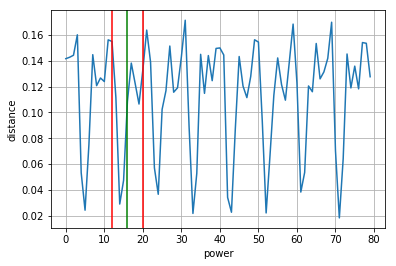

In [668]:
delta = 1 - lmbd
statps = []
powrs = []
dists = []
for i in range(0,int(5/delta)):
    powrs+=[i]
    statp = np.abs((W**i*R).full()).reshape(16)
    statps = [statp]
    dist = np.mean(np.abs(statp-stat_array))
    dists += [dist]
    
plt.plot(powrs, dists)
plt.axvline(x=1/delta+2*n, c='r')
plt.axvline(x=1/delta-2*n, c='r')
plt.axvline(x=1/delta, c='g')

plt.xlabel('power')
plt.ylabel('distance')
plt.grid(True)
plt.show()

It doesn't seem to act as the transition matrix $P$ in the sense that it doesn't mix the MC until convergence to the stationary distribution (or more precisely the quantum state that encodes it) but seems to oscillate around it.

Let us code the approxmate reflexion opertor (ARO) over the stationary distribution. For this we need a certain number of auxillary qubits that depends on the spectral gap with the following relation $O(log_2(1/\sqrt{\delta}))$. The construction of lambda made above assures that for that value $log_2(1/\sqrt{\delta}) = n$. Thus we need $n+1$ auxilliary qubits.

In [680]:
k=n+1

# initialization of the ancilla qubits
Aux = basis(2,0)
for i in range(k):
    Aux = tensor(basis(2,0),Aux)
nullaux = Aux

# construction of multi-qubit gates
eye = qeye(2)
eyes = [eye]
H = hadamard_transform()
Hs = [H]
for i in range(n+6):
    eye = tensor(qeye(2),eye)
    eyes += [eye]
    H = tensor(hadamard_transform(),H)
    Hs += [H]

# contruction of controlled powers of W
temp = W
Wcs = [tensor(eyes[k-1],tensor(fock_dm(2,1),temp-eyes[3])+eyes[4])]
for i in range(1,k):
    temp = temp**2
    Wcs += [tensor(eyes[k-i-1],tensor(fock_dm(2,1),tensor(eyes[i-1],temp)-eyes[i+3])+eyes[i+4])]
Wcs+=[tensor(fock_dm(2,1),tensor(eyes[k-1],temp)-eyes[k+3])+eyes[k+4]]

Mem = tensor(Aux, R)

# Kitaev's modified phase detection circuit
PD = tensor(Hs[k],eyes[3])
for Wc in Wcs:
    PD = Wc*PD
PD = tensor(Hs[k],eyes[3])*PD

# approximate reflection operator
D0aux = 2*nullaux*nullaux.dag()-eyes[k]
ARO = PD.dag()*tensor(D0aux,eyes[3])*PD

We check that the reflection works as expected by applying it to the stationary distribution (it is indeed an exact reflection).

In [669]:
np.power(np.abs(stat.full().reshape(16)),2)

array([ 0.23828125,  0.        ,  0.00585938,  0.00585938,  0.01098633,
        0.65917969,  0.01647949,  0.01647949,  0.00036621,  0.02197266,
        0.00054932,  0.00054932,  0.00036621,  0.02197266,  0.00054932,
        0.00054932])

In [675]:
out = np.array(measure(ARO*tensor(Aux,stat))[1])
out = out.reshape(int(len(out)/16),16)
out = np.sum(out, axis = 0).reshape(4,4)
out

array([[ 0.23828125,  0.        ,  0.00585938,  0.00585938],
       [ 0.01098633,  0.65917969,  0.01647949,  0.01647949],
       [ 0.00036621,  0.02197266,  0.00054932,  0.00054932],
       [ 0.00036621,  0.02197266,  0.00054932,  0.00054932]])

Finally we apply the Grover "one-shot" amplitude amplification algorithm that, as the name indicates, needs only one application of the two reflections (over the flagged actions of cumulated probability 0.25 and over the stationary distribution) to output a distribution with probability one among flagged actions. The only flagged action being $c_1$ (with probability 0.25 in the stationary distribution), we should get as output $[1, 0, 0, 0]$.

In [681]:
null = tensor(basis(2,0),basis(2,0))
refAct = eyes[k+4]-tensor(eyes[k],tensor(2*null*null.dag(),eyes[1]))
Memb = tensor(Aux, stat)
ARO*refAct*Memb

Quantum object: dims = [[2, 2, 2, 2, 2, 2, 2, 2], [1, 1, 1, 1, 1, 1, 1, 1]], shape = (256, 1), type = ket
Qobj data =
[[ 0.97363242]
 [ 0.        ]
 [ 0.15267775]
 [ 0.15267775]
 [ 0.00018959]
 [ 0.00146853]
 [ 0.0002322 ]
 [ 0.0002322 ]
 [ 0.00003461]
 [ 0.00026812]
 [ 0.00004239]
 [ 0.00004239]
 [ 0.00003461]
 [ 0.00026812]
 [ 0.00004239]
 [ 0.00004239]
 [-0.00013027]
 [ 0.        ]
 [ 0.00041536]
 [ 0.00041536]
 [-0.00078632]
 [ 0.00017494]
 [-0.0002322 ]
 [-0.0002322 ]
 [-0.00014356]
 [ 0.00003194]
 [-0.00004239]
 [-0.00004239]
 [-0.00014356]
 [ 0.00003194]
 [-0.00004239]
 [-0.00004239]
 [-0.00029577]
 [ 0.        ]
 [ 0.00094307]
 [ 0.00094307]
 [-0.00178531]
 [ 0.0003972 ]
 [-0.00052719]
 [-0.00052719]
 [-0.00032595]
 [ 0.00007252]
 [-0.00009625]
 [-0.00009625]
 [-0.00032595]
 [ 0.00007252]
 [-0.00009625]
 [-0.00009625]
 [ 0.00071642]
 [ 0.        ]
 [ 0.00011234]
 [ 0.00011234]
 [-0.00005128]
 [-0.0003972 ]
 [-0.0000628 ]
 [-0.0000628 ]
 [-0.00000936]
 [-0.00007252]
 [-0.0000114

In [682]:
mes = np.array(measure(ARO*refAct*Memb)[1])
mes = mes.reshape(int(len(mes)/16),16)
mes = np.sum(mes, axis = 0).reshape(4,4)
np.sum(mes, axis = 0)

array([ 0.95152907,  0.00079433,  0.0238383 ,  0.0238383 ])

Close enough.

<h3>Showing the $O(1/\sqrt{\delta})$ dependency</h3>

In order to get a good granularity of our deltas, we don't take only integer values of $n$ (formally the number of ancilla qubits). What we do is we take integer values of the number of calls $c$ to the Szegedy walk operator $W$, and the *logical* number of ancilla qubits associated to that number will be $k = log_2(c)$ (so actually $\lceil log_2(c) \rceil$ ancilla qubits are used). Then all we have to do is not to allow a number of calls to $W$ that is greater than $c$ in the Phase Detection algorithm, as if we would have taken $k$ ancilla qubits.

Let us run the simlation:

In [64]:
R1 = tensor(basis(2,0),basis(2,0))
R2 = tensor(basis(2,0),basis(2,0))
R = tensor(R1,R2)

Ut3 = controlled_gate(ry(pi/2))
Urt3 = controlled_gate(ry(pi/2))

null = tensor(basis(2,0),basis(2,0))
D0 = 2*null*null.dag()-tensor(qeye(2),qeye(2))

n = 5
nb_agnts = 1000

Aux = basis(2,0)
Auxs = [Aux]
for i in range(n+1):
    Aux = tensor(basis(2,0),Aux)
    Auxs += [Aux]

eye = qeye(2)
eyes = [eye]
H = hadamard_transform()
Hs = [H]
for i in range(n+6):
    eye = tensor(qeye(2),eye)
    eyes += [eye]
    H = tensor(hadamard_transform(),H)
    Hs += [H]

NUss = []
deltas = []
old_perc = 0
for c in range(2,2**n):
    k = math.log2(c)
    lmbd = 1 - 2**(-2*k)
    deltas += [1-lmbd]
    p2 = lmbd
    p1 = (1-lmbd)/4
    p3 = 1-p1-p2
    distrib = [p1,p2,p3/2,p3/2]

    Ut1 = tensor(ry(2*math.acos(sqrt(p1+p2))),qeye(2))
    Ut2 = controlled_gate(ry(2*math.acos(sqrt(p1/(p1+p2)))), control_value=0)
    Ut2b = controlled_gate(ry(2*math.acos(sqrt((p1+lmbd)/(p1+p2)))), control_value=0)

    U1 = Ut3*Ut2b*Ut1
    U2 = Ut3*Ut2*Ut1

    U1tempc00 = tensor(tensor(fock_dm(2, 0), fock_dm(2, 0)),U1*U2.dag()-eyes[1])+eyes[3]

    Pb = np.array([distrib]*4).transpose()
    Pb[0][0] += lmbd
    Pb[1][0] -= lmbd
    stat_distrib = [p1/(1-lmbd),p2-p1*lmbd/(1-lmbd),p3/2,p3/2]
    Pb_rvrs = Pb*np.array(stat_distrib)
    Pb_rvrs = Pb_rvrs.transpose()/np.array(stat_distrib)

    prv1 = Pb_rvrs[:,0]
    prv2 = Pb_rvrs[:,1]
    prv3 = Pb_rvrs[:,2]

    Urt1 = tensor(ry(2*math.acos(sqrt(prv1[0]+prv1[1]))),qeye(2))
    Urt1b = tensor(ry(2*math.acos(sqrt(prv2[0]+prv2[1]))),qeye(2))
    Urt1c = tensor(ry(2*math.acos(sqrt(prv3[0]+prv3[1]))),qeye(2))
    Urt2 = controlled_gate(ry(2*math.acos(sqrt(prv1[0]/(prv1[0]+prv1[1])))), control_value=0)
    Urt2b = controlled_gate(ry(2*math.acos(sqrt(prv2[0]/(prv2[0]+prv2[1])))), control_value=0)
    Urt2c = controlled_gate(ry(2*math.acos(sqrt(prv3[0]/(prv3[0]+prv3[1])))), control_value=0)

    Ur1 = Urt3*Urt2*Urt1
    Ur2 = Urt3*Urt2b*Urt1b
    Ur3 = Urt3*Urt2c*Urt1c

    Ur1c00 = tensor(tensor(fock_dm(2, 0), fock_dm(2, 0)),Ur1*Ur3.dag()-eyes[1])+eyes[3]
    Ur2c01 = tensor(tensor(fock_dm(2, 0), fock_dm(2, 1)),Ur2*Ur3.dag()-eyes[1])+eyes[3]

    Up = U1tempc00*tensor(eyes[1],U2)
    Vp_temp = Ur1c00*Ur2c01*tensor(eyes[1],Ur3)
    Vp = swap(N=4, targets=[0, 2])*swap(N=4, targets=[1, 3])*Vp_temp*swap(N=4, targets=[0, 2])*swap(N=4, targets=[1, 3])
    refA = Up*tensor(eyes[1],D0)*Up.dag()
    refB = Vp*tensor(D0,eyes[1])*Vp.dag()
    W = refB*refA
    
    kk = math.ceil(k)
    # nb ancilla = kk+1, position kk in lists

    nullaux = Auxs[kk]

    temp = W
    Ws = [tensor(fock_dm(2,1),temp-eyes[3])+eyes[4]]
    for i in range(1,kk):
        temp = temp**2
        Ws += [tensor(fock_dm(2,1),tensor(eyes[i-1],temp)-eyes[i+3])+eyes[i+4]]
    temp = temp**2
    Ws+=[tensor(fock_dm(2,1),tensor(eyes[kk-1],temp)-eyes[kk+3])+eyes[kk+4]]

    def gen_Wcs(Ws, c, kk):
        tmp = random.randint(0, c)
        binary = [int(x) for x in bin(tmp)[2:]][::-1]
        binary = binary + [0]*(kk+1-len(binary))
        Wcs=[]
        for i, b in enumerate(binary[:-1]):
            if b:
                Wcs += [tensor(eyes[kk-i-1],Ws[i])]
            else:
                Wcs += [False]
        if binary[-1]:
            Wcs += [Ws[-1]]
        return(Wcs, tmp*4)

    D0aux = 2*nullaux*nullaux.dag()-eyes[kk]
    stat_1 = sqrt(p1/(1-lmbd))*tensor(basis(2,0),basis(2,0))+sqrt(p2-p1*lmbd/(1-lmbd))*tensor(basis(2,0),basis(2,1))+sqrt(p3/2)*tensor(basis(2,1),basis(2,0))+sqrt(p3/2)*tensor(basis(2,1),basis(2,1))
    stat = Up*tensor(stat_1,R2)
    refAct = eyes[kk+4]-tensor(eyes[kk],tensor(2*null*null.dag(),eyes[1]))
    Memb = tensor(Auxs[kk], stat)
    
    NUs = []
    for a in range(nb_agnts):
        NU = 0
        fnd = False
        while not fnd:
            Wcs, nb_calls = gen_Wcs(Ws, c, kk)
            NU += nb_calls

            PD = tensor(Hs[kk],eyes[3])
            for Wc in Wcs:
                if Wc!=False:
                    PD = Wc*PD
            PD = tensor(Hs[kk],eyes[3])*PD
            ARO = PD.dag()*tensor(D0aux,eyes[3])*PD

            res = np.array(measure(ARO*refAct*Memb)[1])
            res = res.reshape(int(len(res)/16),16)
            res = np.sum(res, axis = 0).reshape(4,4)
            res = np.sum(res, axis = 0)
            mes = measure(Qobj(np.sqrt(res)))[0]
            if mes == 0:
                fnd = True
        NUs+=[NU]
    NUss+=[NUs]
    perc = 100*c/2**n
    if perc >= old_perc+5:
        old_perc = 20*int(perc/20)
        print(int(perc),"%")
print("done")

6 %
9 %
12 %
15 %
18 %
21 %
25 %
28 %
31 %
34 %
37 %
40 %
46 %
50 %
53 %
56 %
59 %
62 %
65 %
68 %
71 %
75 %
78 %
81 %
87 %
90 %
93 %
96 %
done


In [65]:
import pickle
f = open('simulation_delta_noerror.save', 'wb')
pickle.dump([deltas, NUss], f)
f.close()

In [6]:
import pickle
file = open('simulation_delta_noerror.save', 'rb')
[deltas, NUss] = pickle.load(file)
file.close()

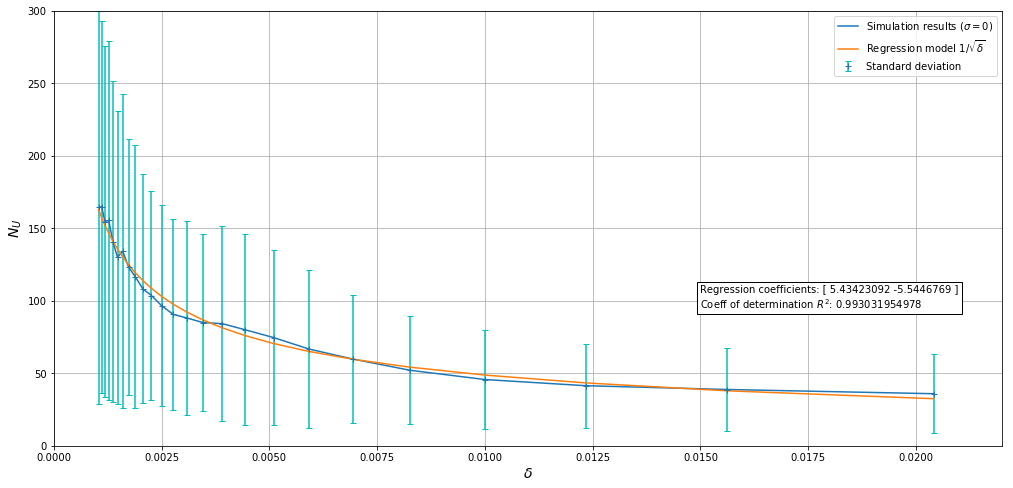

Curve fitting coefficients :  [ 5.43423092 -5.5446769 ]
Coefficient of determination R^2 :  0.993031954978


In [7]:
NUss_mean = []
NUss_std = []
for NUs in NUss:
    NUss_mean+=[np.mean(NUs)]
    NUss_std+=[np.std(NUs)]

curve_fit = np.polyfit(1/np.sqrt(deltas), NUss_mean, 1, full=True)
coeff = curve_fit[0]
res = curve_fit[1][0]
rsqr = 1 - res / (len(NUss_mean) * np.var(NUss_mean))

plt.figure(figsize=(17,8))
results, = plt.plot(deltas[5:], NUss_mean[5:], label='Simulation results ($\sigma=0$)')
model, = plt.plot(deltas[5:], coeff[0]/np.sqrt(deltas[5:])+coeff[1], label='Regression model $1/\sqrt{\delta}$')
errbar = plt.errorbar(deltas[5:], NUss_mean[5:], NUss_std[5:], ecolor='c', linestyle='None', marker='+', capsize=3, label='Standard deviation')
axes = plt.gca()
axes.set_ylim([0,300])
axes.set_xlim([0,0.022])

plt.legend(handles=[results, model, errbar])
plt.text(0.015,95,'Regression coefficients: '+str(coeff)+'\nCoeff of determination $R^2$: '+str(rsqr),bbox=dict(facecolor='white',edgecolor='black',boxstyle='square'))
plt.xlabel('$\delta$', fontsize=14)
plt.ylabel('$N_U$', fontsize=14)
plt.grid(True)
plt.show()
print("Curve fitting coefficients : ", coeff)
print('Coefficient of determination R^2 : ', rsqr)

<h3>Introducing the error model for the trapped ions implementation</h3>

The *first order approximation* error model we use is thouroughly explained in the report of this project and the different sets of simulations can be found in the other Jupyter notebooks, both on the same Github repository.